# Intro

First, to augment the dataset, we take each image and flip it along the x axis; the y axis; and both.

Then, we split it into train/val/test sets

In [1]:
import numpy as np
import os
import cv2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import re
from skimage.io import imread

In [2]:
root = "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/2025_12_8_Channeled_Combined/"

masks_root_path = root + "ann/"
images_root_path = root + "img/"

# image_file_extension = "tiff"
image_file_extension = "jpg"

In [3]:
category_mapping = {0: "dark", 1: "busbar", 2: "crack", 3: "non-cell"}


def inference_and_show(img, gt_mask):
    fig, ax = plt.subplots(ncols=4, nrows=2, figsize=(10, 10), layout="compressed")

    ax[0, 0].imshow(img, cmap="gray", interpolation="None")
    ax[0, 0].axis("off")
    ax[0, 0].set_title("(a) EL image", fontsize="xx-large")
    ##
    for i in range(4):
        ax[1, i].imshow(gt_mask[i], cmap="viridis", interpolation="None")
        ax[1, i].axis("off")
        ax[1, i].set_title(f"({i}) {category_mapping[i]} activation")

---

## Split, then Flip, Rotate, Mirror

We split the original data first to prevent leakage, then augment each set.

In [4]:
def flip_my_mask(mask, flip_dir):
    channels = []
    for c in range(mask.shape[0]):
        channel = mask[c]
        flipped_channel = np.flip(channel, flip_dir)
        channels.append(flipped_channel)
    flipped_mask = np.stack(channels, axis=0)
    return flipped_mask

mask_load_path = masks_root_path + "channeled/"
image_load_path = images_root_path + "original/"

# Get sorted lists
all_masks = sorted([f for f in os.listdir(mask_load_path) if f.endswith('.npy')])
all_images = sorted([f for f in os.listdir(image_load_path) if not f.startswith('.') and not os.path.isdir(image_load_path + f)])

# Split originals
masks_train, masks_val, imgs_train, imgs_val = train_test_split(all_masks, all_images, test_size=0.2, random_state=42, shuffle=False)

def process_subset(mask_list, img_list, subset_name):
    print(f"Processing {subset_name} set...")
    
    # Ensure directories exist
    os.makedirs(masks_root_path + subset_name, exist_ok=True)
    os.makedirs(images_root_path + subset_name, exist_ok=True)
    os.makedirs(masks_root_path + "all", exist_ok=True)
    os.makedirs(images_root_path + "all", exist_ok=True)
    # Mirrored dirs
    for m_dir in ["mirrored_y", "mirrored_x", "mirrored_xy"]:
        os.makedirs(masks_root_path + m_dir, exist_ok=True)
        os.makedirs(images_root_path + m_dir, exist_ok=True)

    for mask_name, img_name in zip(mask_list, img_list):
        # Load
        mask = np.load(mask_load_path + mask_name, allow_pickle=True)
        img = cv2.imread(image_load_path + img_name)
        
        def save_variant(m, i, prefix=""):
            m_name = prefix + mask_name
            i_name = prefix + img_name
            
            # Subset
            np.save(masks_root_path + subset_name + "/" + m_name, m, allow_pickle=False)
            cv2.imwrite(images_root_path + subset_name + "/" + i_name, i)
            
            # All
            np.save(masks_root_path + "all/" + m_name, m, allow_pickle=False)
            cv2.imwrite(images_root_path + "all/" + i_name, i)
            
            # Mirrored specific
            if prefix == "my_":
                np.save(masks_root_path + "mirrored_y/" + m_name, m, allow_pickle=False)
                cv2.imwrite(images_root_path + "mirrored_y/" + i_name, i)
            elif prefix == "mx_":
                np.save(masks_root_path + "mirrored_x/" + m_name, m, allow_pickle=False)
                cv2.imwrite(images_root_path + "mirrored_x/" + i_name, i)
            elif prefix == "mxy_":
                np.save(masks_root_path + "mirrored_xy/" + m_name, m, allow_pickle=False)
                cv2.imwrite(images_root_path + "mirrored_xy/" + i_name, i)

        # Original
        save_variant(mask, img, "")
        
        # Mirror Y
        mask_y = flip_my_mask(mask, 1)
        img_y = np.flip(img, 1)
        save_variant(mask_y, img_y, "my_")
        
        # Mirror X
        mask_x = flip_my_mask(mask, 0)
        img_x = np.flip(img, 0)
        save_variant(mask_x, img_x, "mx_")
        
        # Mirror XY
        mask_xy = flip_my_mask(mask_x, 1)
        img_xy = np.flip(img_x, 1)
        save_variant(mask_xy, img_xy, "mxy_")

process_subset(masks_train, imgs_train, "train")
process_subset(masks_val, imgs_val, "val")

Processing train set...
Processing val set...


----
# confirmation

after rotation and flipping, ensure that all channels of masks were rotated too

/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/2025_12_8_Channeled_Combined/ann/all/my_SW3-DH3000-1500h-PT-cell44-r180.npy
/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/2025_12_8_Channeled_Combined/img/all/my_SW3-DH3000-1500h-PT-cell44-r180.jpg
/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/2025_12_8_Channeled_Combined/ann/all/mx_SW3-DH3000-1500h-PT-cell44-r180.npy
/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/2025_12_8_Channeled_Combined/img/all/mx_SW3-DH3000-1500h-PT-cell44-r180.jpg
/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/2025_12_8_Channeled_Combined/ann/all/mxy_SW3-DH3000-1500h-PT-cell44-r180.npy
/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/2025_12_8_Channeled_Combined/img/all/mxy_SW3-DH3000-1500h-PT-cell44-r180.jpg
/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/2025_12_8_Channeled_Combined/ann/all/my_1_EL_18.09.2023-15-40-40_unknownID_ASU Minisample_SHJ5_103.npy
/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/2025_12_8_Channeled_Combined/img/all/my_1_EL_18.09.2023-15-40-40_unknownID_ASU 

/var/folders/_l/7n7n98ws5fx8zfcbxfmfs7fh0000gn/T/ipykernel_10260/2485254792.py:29: FutureWarning: The plugin infrastructure in `skimage.io` and the parameter `plugin` are deprecated since version 0.25 and will be removed in 0.27 (or later). To avoid this warning, please do not use the parameter `plugin`. Instead, use `imageio` or other I/O packages directly. See also `imread`.
  image = imread(img_path, plugin="pil")
/var/folders/_l/7n7n98ws5fx8zfcbxfmfs7fh0000gn/T/ipykernel_10260/2485254792.py:29: FutureWarning: The plugin infrastructure in `skimage.io` and the parameter `plugin` are deprecated since version 0.25 and will be removed in 0.27 (or later). To avoid this warning, please do not use the parameter `plugin`. Instead, use `imageio` or other I/O packages directly. See also `imread`.
  image = imread(img_path, plugin="pil")
/var/folders/_l/7n7n98ws5fx8zfcbxfmfs7fh0000gn/T/ipykernel_10260/2485254792.py:29: FutureWarning: The plugin infrastructure in `skimage.io` and the parameter 

/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/2025_12_8_Channeled_Combined/ann/all/mxy_1_EL_18.09.2023-15-40-40_unknownID_ASU Minisample_SHJ5_103.npy
/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/2025_12_8_Channeled_Combined/img/all/mxy_1_EL_18.09.2023-15-40-40_unknownID_ASU Minisample_SHJ5_103.jpg
/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/2025_12_8_Channeled_Combined/ann/all/my_SW2-DH3000-1500h-PT-cell54-flr.npy
/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/2025_12_8_Channeled_Combined/img/all/my_SW2-DH3000-1500h-PT-cell54-flr.jpg
/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/2025_12_8_Channeled_Combined/ann/all/mx_SW2-DH3000-1500h-PT-cell54-flr.npy
/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/2025_12_8_Channeled_Combined/img/all/mx_SW2-DH3000-1500h-PT-cell54-flr.jpg
/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/2025_12_8_Channeled_Combined/ann/all/mxy_SW2-DH3000-1500h-PT-cell54-flr.npy
/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/2025_12_8_Channeled_Combined/img/all/mxy_SW2-DH3000-1500

/var/folders/_l/7n7n98ws5fx8zfcbxfmfs7fh0000gn/T/ipykernel_10260/2485254792.py:29: FutureWarning: The plugin infrastructure in `skimage.io` and the parameter `plugin` are deprecated since version 0.25 and will be removed in 0.27 (or later). To avoid this warning, please do not use the parameter `plugin`. Instead, use `imageio` or other I/O packages directly. See also `imread`.
  image = imread(img_path, plugin="pil")
/var/folders/_l/7n7n98ws5fx8zfcbxfmfs7fh0000gn/T/ipykernel_10260/2485254792.py:29: FutureWarning: The plugin infrastructure in `skimage.io` and the parameter `plugin` are deprecated since version 0.25 and will be removed in 0.27 (or later). To avoid this warning, please do not use the parameter `plugin`. Instead, use `imageio` or other I/O packages directly. See also `imread`.
  image = imread(img_path, plugin="pil")
/var/folders/_l/7n7n98ws5fx8zfcbxfmfs7fh0000gn/T/ipykernel_10260/2485254792.py:29: FutureWarning: The plugin infrastructure in `skimage.io` and the parameter 

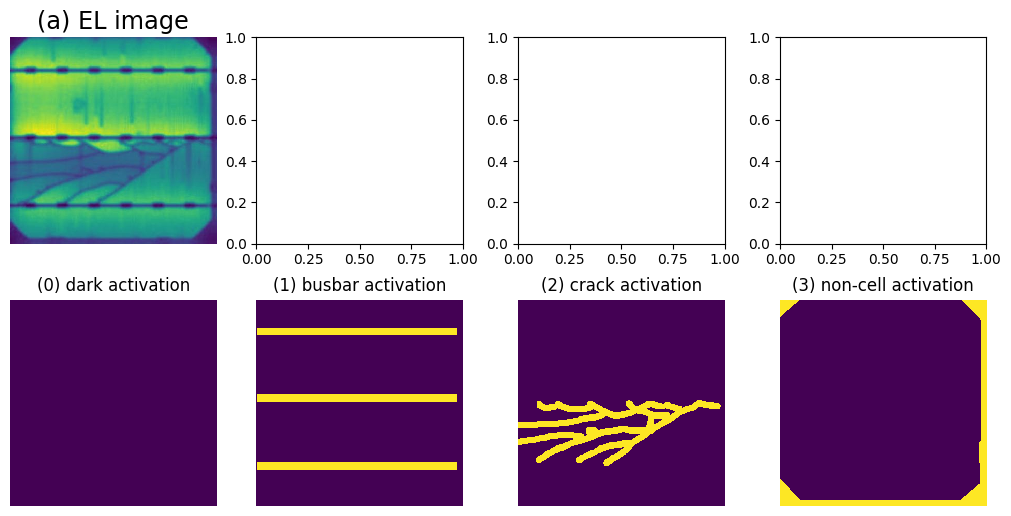

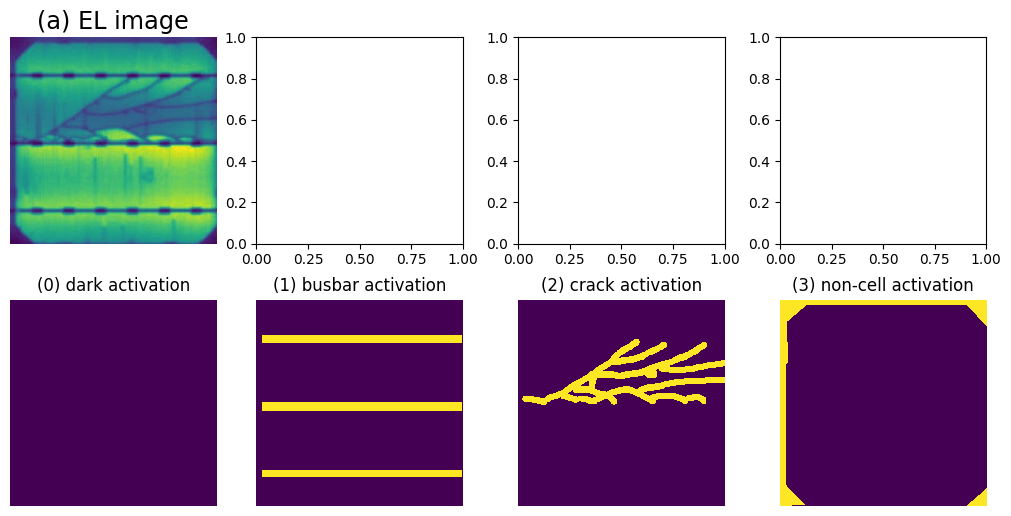

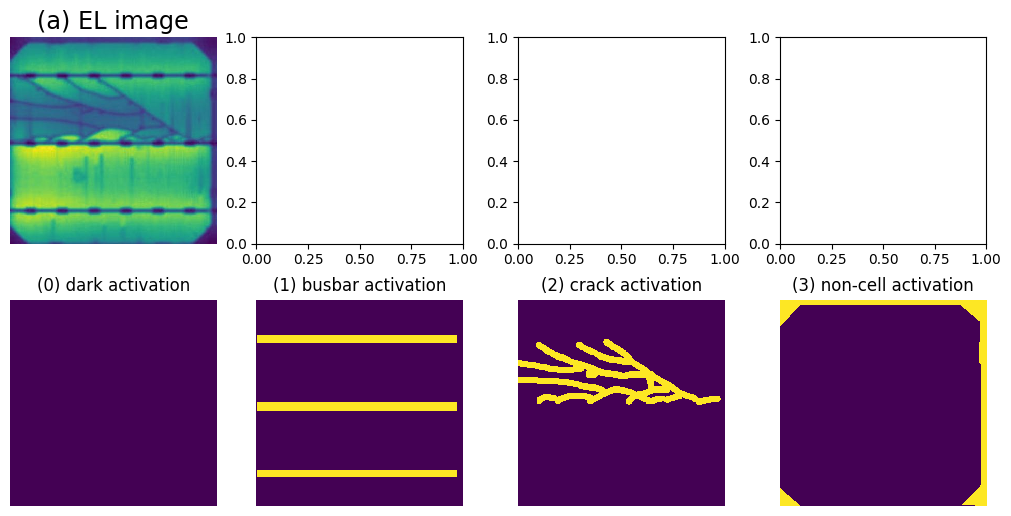

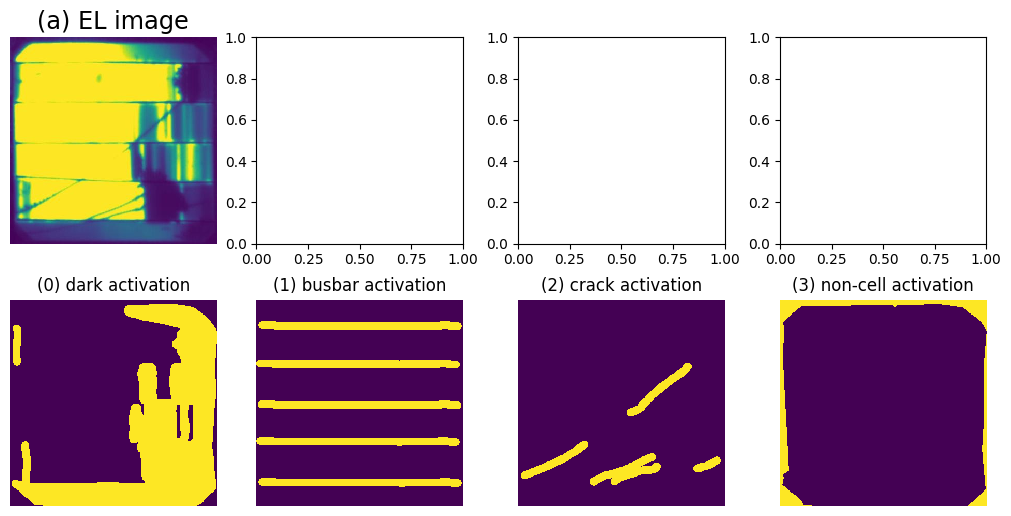

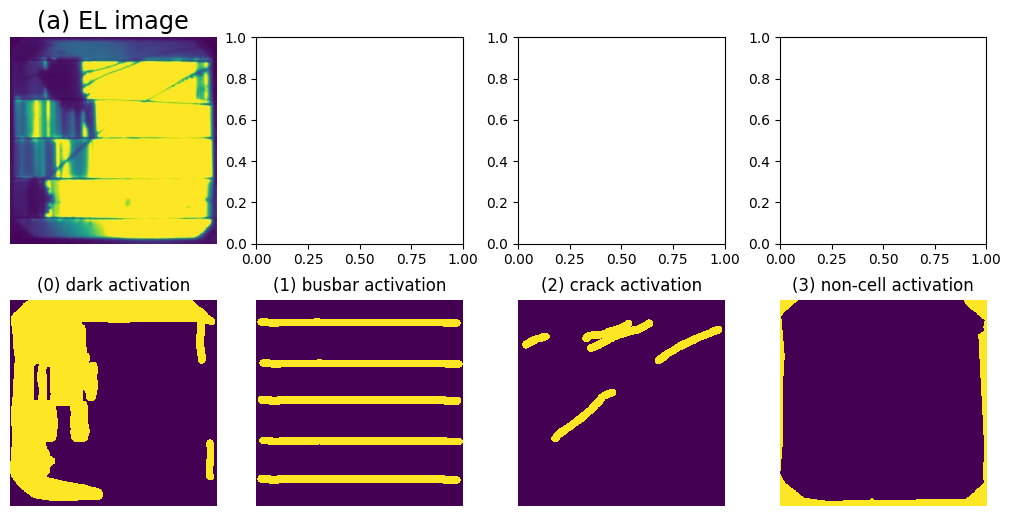

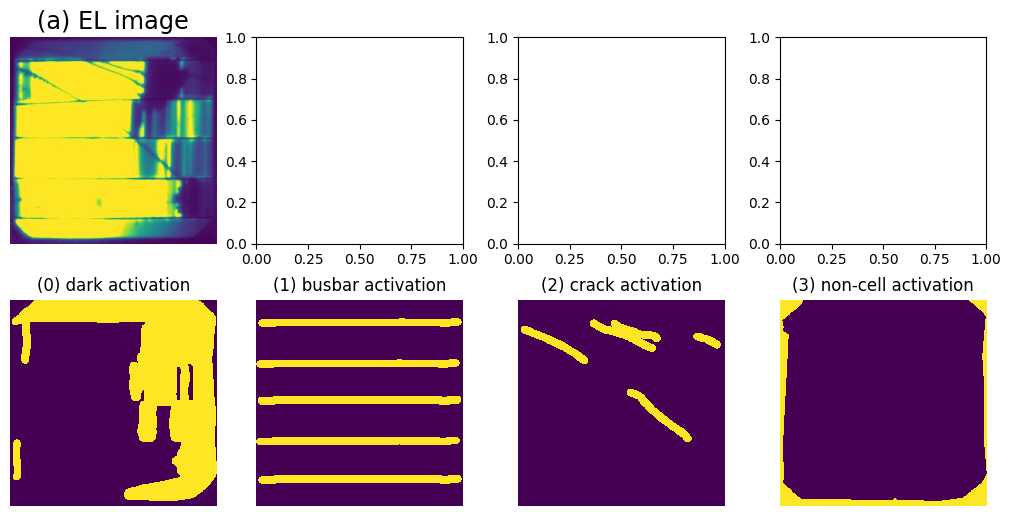

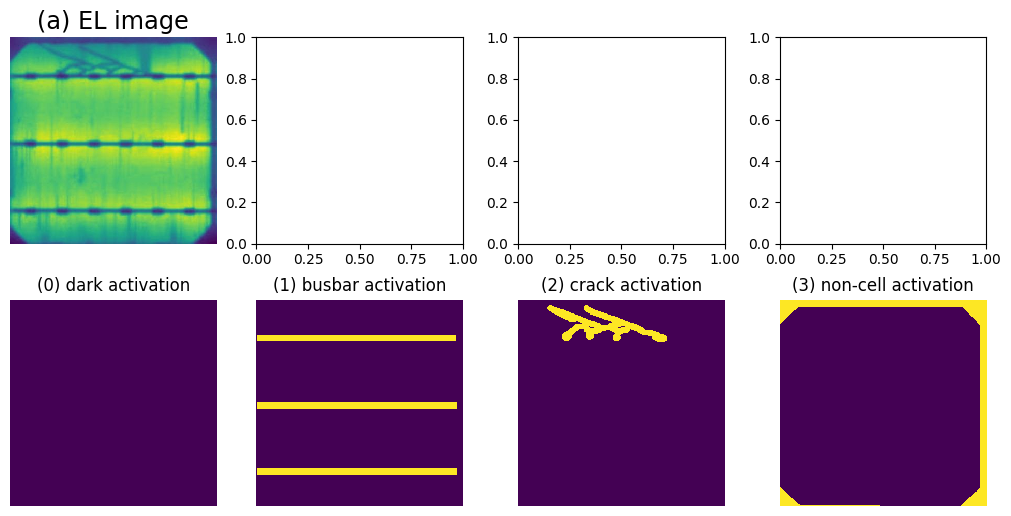

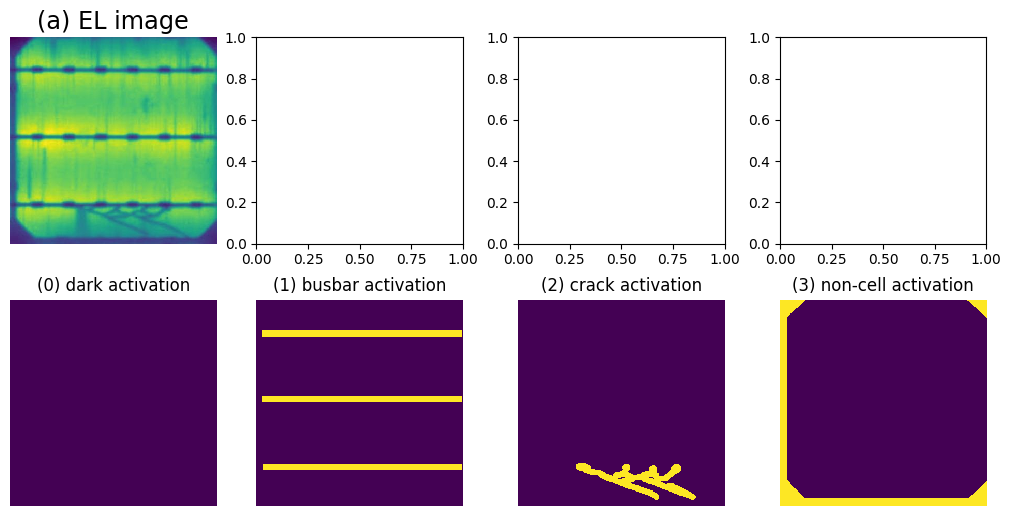

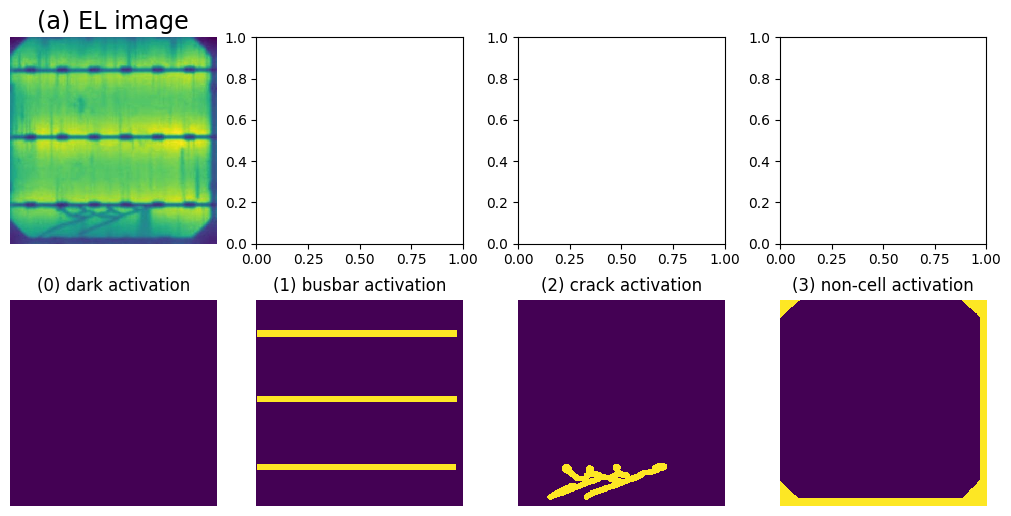

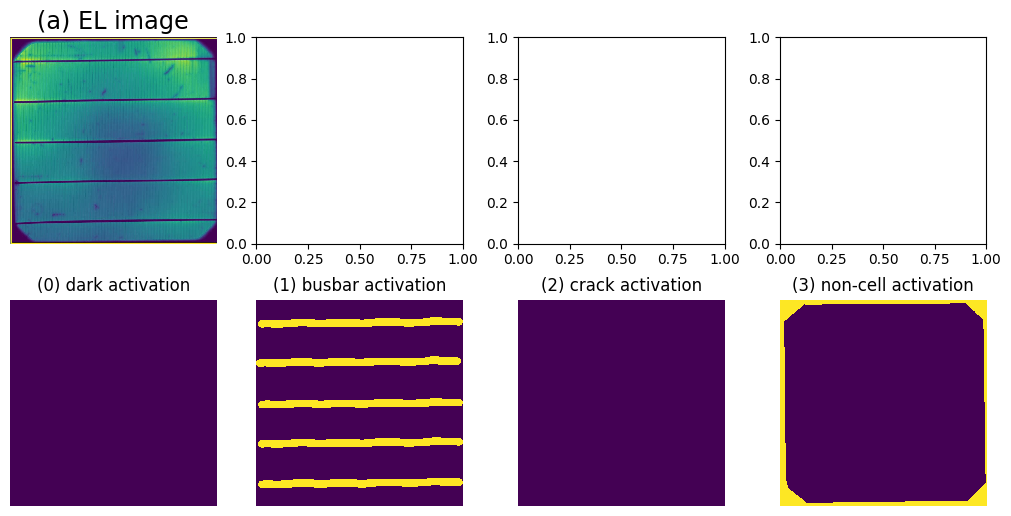

In [5]:
img_folder = root + "img/all/"
mask_folder = root + "ann/all/"

files = [c for c in os.listdir(mask_folder)]

npy_regex_string = r"^(.*?)(?=\.npy)"

n_masks = [re.search(npy_regex_string, f).group(1) for f in files]

raw_mask_names = []
custom_mask_list = []

for mask_name in n_masks:
    if not mask_name.startswith("m"):
        raw_mask_names.append(mask_name)

for raw_mask_name in raw_mask_names:
    for additive in ["my_", "mx_", "mxy_"]:
        custom_mask_name = f"{additive}{raw_mask_name}"
        custom_mask_list.append(custom_mask_name)

for this_mask in custom_mask_list[0:10]:
    mask_path = os.path.join(mask_folder, f"{this_mask}.npy")
    img_path = os.path.join(img_folder, f"{this_mask}.{image_file_extension}")

    print(mask_path)
    print(img_path)

    image = imread(img_path, plugin="pil")
    loaded_mask = np.load(mask_path, allow_pickle=True)

    inference_and_show(image, loaded_mask)